# Project 1: Detecting Moving Objects in DAS Recordings
Małgorzata Gierdewicz, ID:148264



# Set-up
Before I start loading the data, I copy the function from the cv labs to show images in google colab

In [324]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

# Loading the data

In this section I load the data from the npy files. I use the code provided in the **example of loading and displaying input data:** https://drive.google.com/file/d/1TTCqmtQ2ddT5l401RGq3ngQa0NtJsfYD/view?usp=sharing.

In [325]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize


def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels

In [326]:
path_out = '092'
files = glob.glob(path_out+"*", root_dir= '/content/drive/MyDrive/cvproject1')
files.sort()

In [327]:
print(files)

['092322.npy', '092332.npy', '092342.npy', '092352.npy', '092402.npy', '092412.npy', '092422.npy', '092432.npy', '092442.npy', '092452.npy', '092502.npy', '092512.npy']


In [328]:
from pathlib import Path
dx= 5.106500953873407
dt= 0.0016

path_out = '092'
data = []
first_filename = files[0]
first_filepath = Path('/content/drive/MyDrive/cvproject1') / first_filename
for f_name in files:
   filepath = Path('/content/drive/MyDrive/cvproject1') / f_name
   data.append(np.load(filepath, allow_pickle=True))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

# Loading images from arrays

I changed the function used to display the plot in **Example of loading and displaying input data:** https://drive.google.com/file/d/1TTCqmtQ2ddT5l401RGq3ngQa0NtJsfYD/view?usp=sharing so that I can use it to plot data from ndarrays without downloading a picture in a png format. I wrote this function because displaying ndarray data from imshow in the setup section was impossible

In [329]:
#load the images frtom arrays

def show_image(arr):
  fig = plt.figure(figsize=(12,16))
  ax = plt.axes()
  df = pd.DataFrame(data=arr, index=index, columns=columns)
  #maybe if something is in the upper quartile then use some form of magnitude???? like multiply it b6y some number
  low, high = np.percentile(df, [3, 98])
  norm = Normalize(vmin=low, vmax=high, clip=True)

  #moved out norm from this function, will use it in data later

  im = ax.imshow(df,interpolation='none',aspect='auto', norm = norm)
  plt.ylabel('time')
  plt.xlabel('space [m]')
  cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
  plt.colorbar(im, cax=cax)
  x_positions, x_labels = set_axis(df.columns)
  ax.set_xticks(x_positions, np.round(x_labels))
  y_positions, y_labels = set_axis(df.index.time)
  ax.set_yticks(y_positions, y_labels)
  plt.show()
  img = np.save('data.npy', arr)
  return img

The time in which data was captured spans 2 minutes.

The image loaded directly from the arrays is noisy and wil need preprocessing before I use it to detect lines

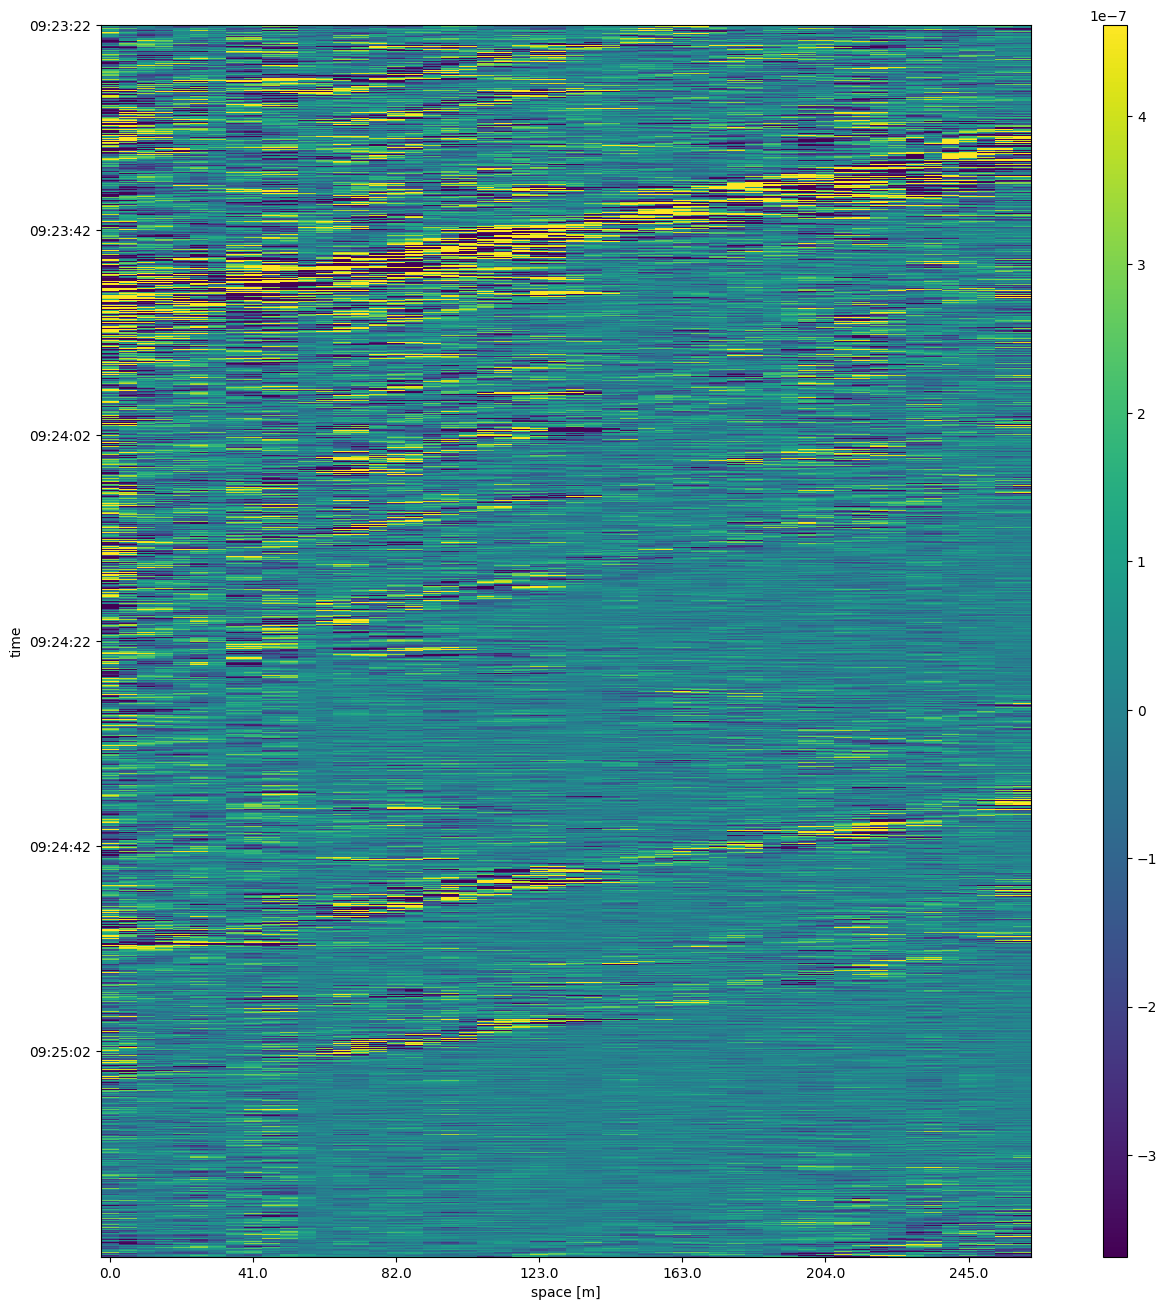

In [330]:
show_image(df)


# Data Filtering

My first attempt in denoising the data was with the fast fourier transform presentet in lab 5. By transforming the image to the frequency domain, I can calculate the frequencies that will be the noise using fftfreq, get them filtered out and convert the data back to the intensity domain using the inverse fft function. The fft and ifft functions written below weren't used at the end since the fft one is for a 2D data while mine has only 1D. I also found it easier to implement the data directly from the np library.

In [331]:
def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum


def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

Before the filtering, I normalized my data so that the results will be in the interval between 0 and 1, so that there won't be extremely small data points with the signs of them varying. This could complicate the further calculations.

In [332]:
#data normalization between 0 and 1
data = (data - np.min(data)) / (np.max(data) - np.min(data))
data

array([[0.37347603, 0.3702973 , 0.3702973 , ..., 0.37186655, 0.37013638,
        0.3696938 ],
       [0.37420028, 0.3710216 , 0.37041804, ..., 0.37271154, 0.3685269 ,
        0.3689695 ],
       [0.37520617, 0.37065944, 0.36933166, ..., 0.3715849 , 0.36816478,
        0.36772218],
       ...,
       [0.3741198 , 0.375005  , 0.37327483, ..., 0.36997545, 0.38518485,
        0.38578844],
       [0.37420028, 0.37593046, 0.37440148, ..., 0.37613165, 0.38470203,
        0.3842192 ],
       [0.37568903, 0.37717777, 0.37496477, ..., 0.38043693, 0.38043693,
        0.3786263 ]], dtype=float32)

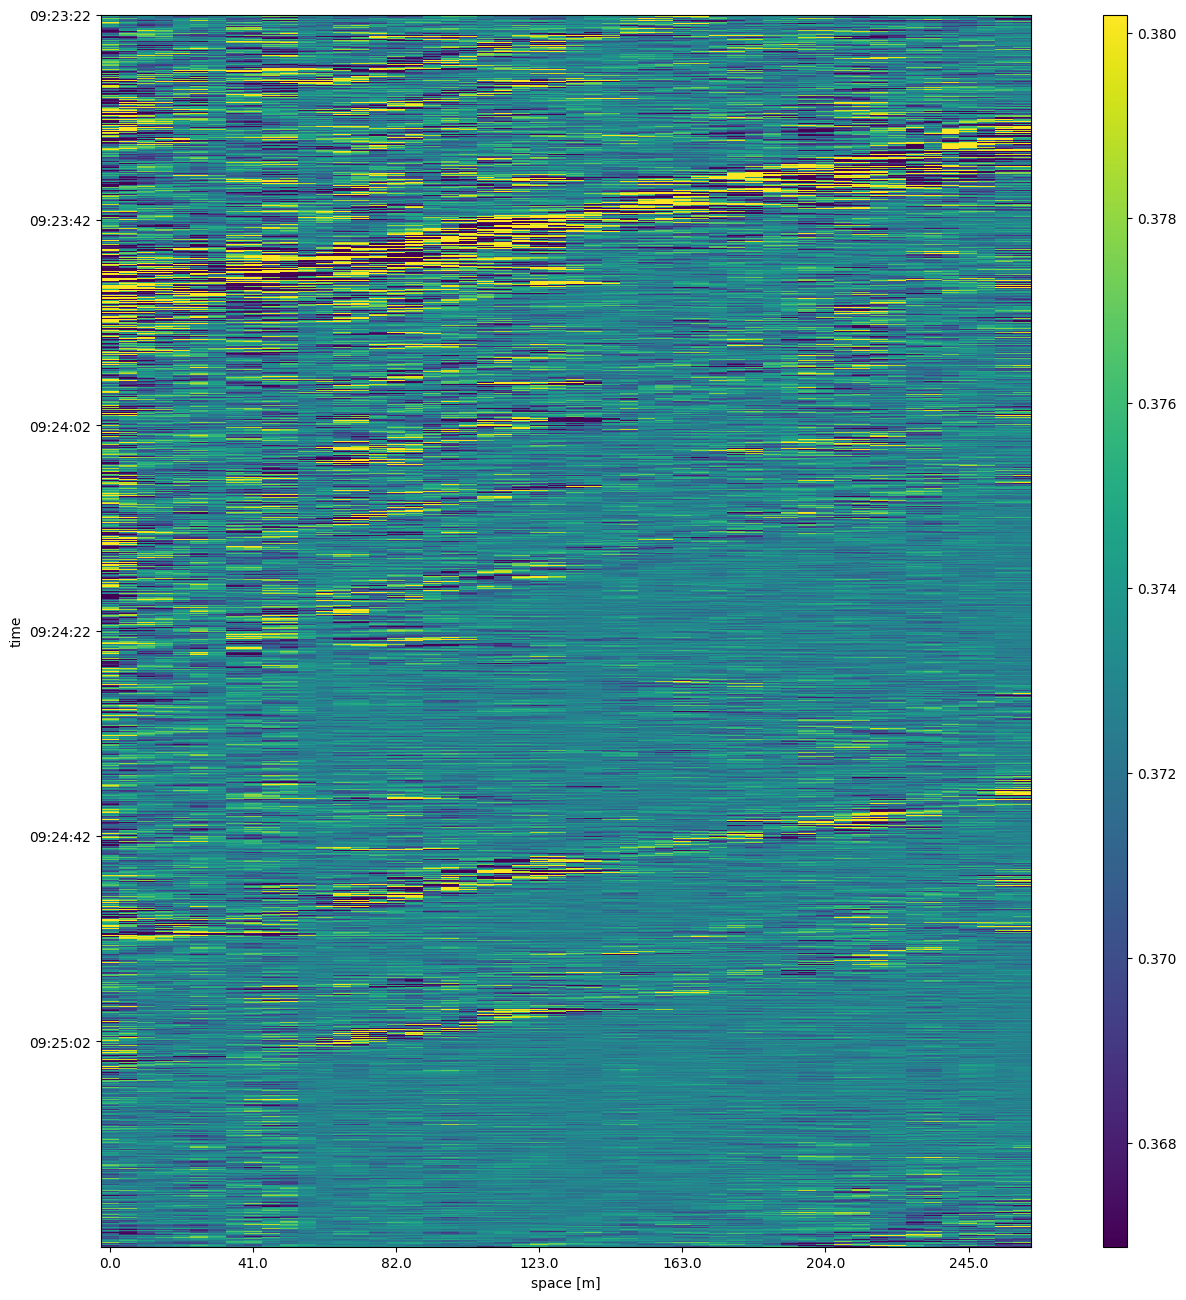

In [333]:
show_image(data)

Here I tested the conversion to frequency domain and back. I show the frequencies and the image reconstructed from them.

(75000, 52)


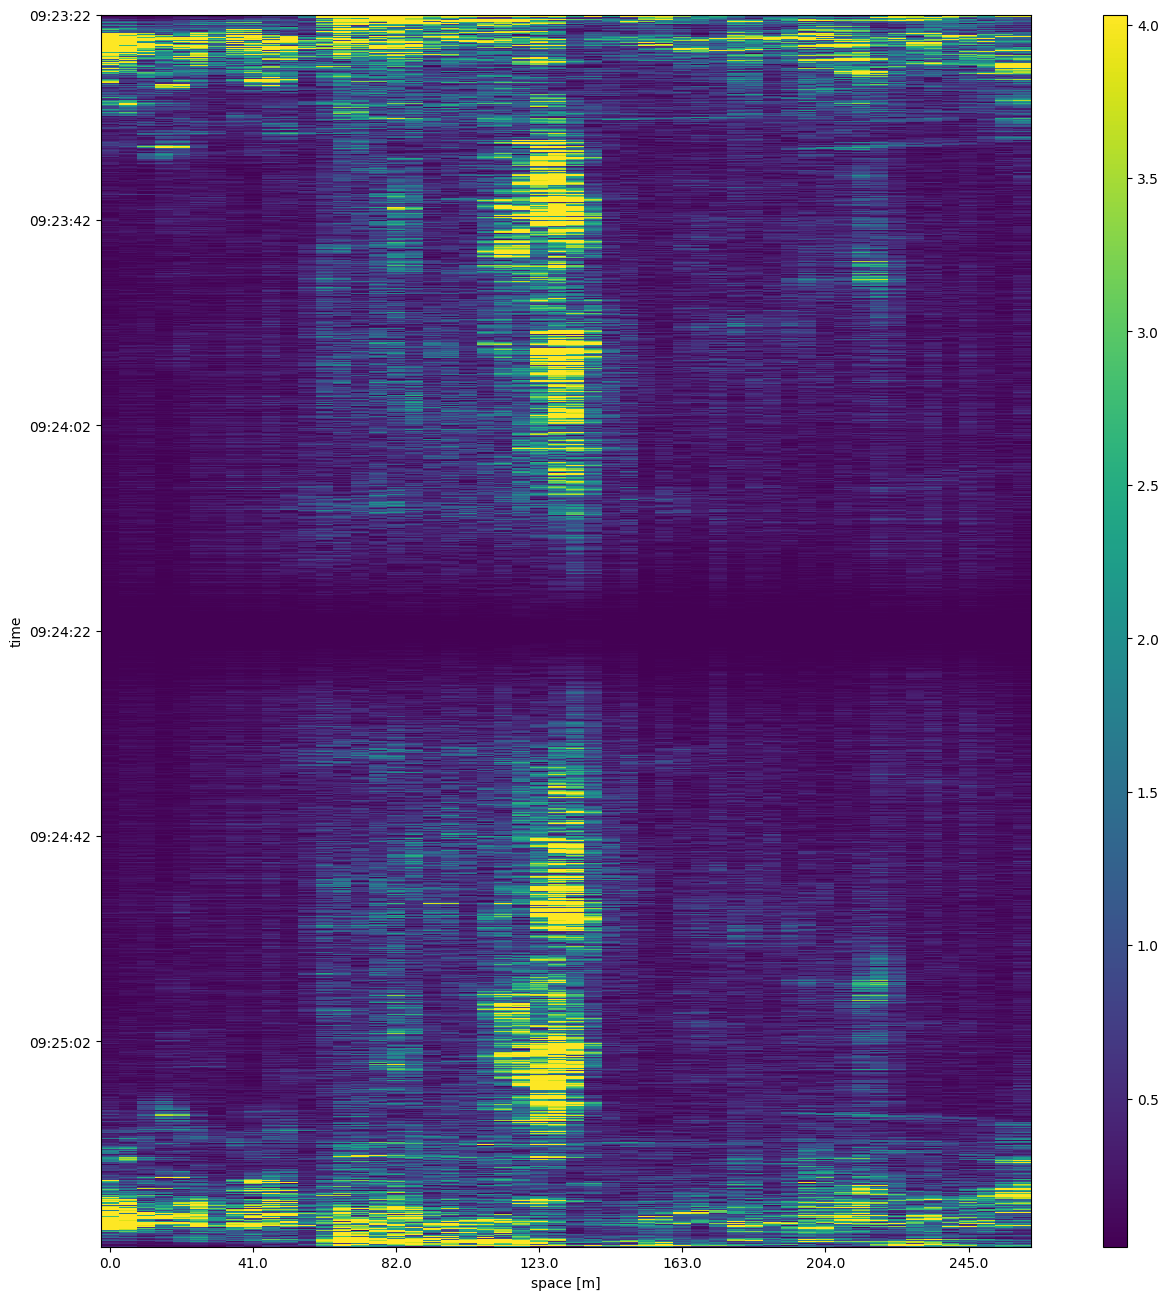

<ipython-input-334-d7f6e63994dd>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  img = ((i) * 255).astype(np.uint8)


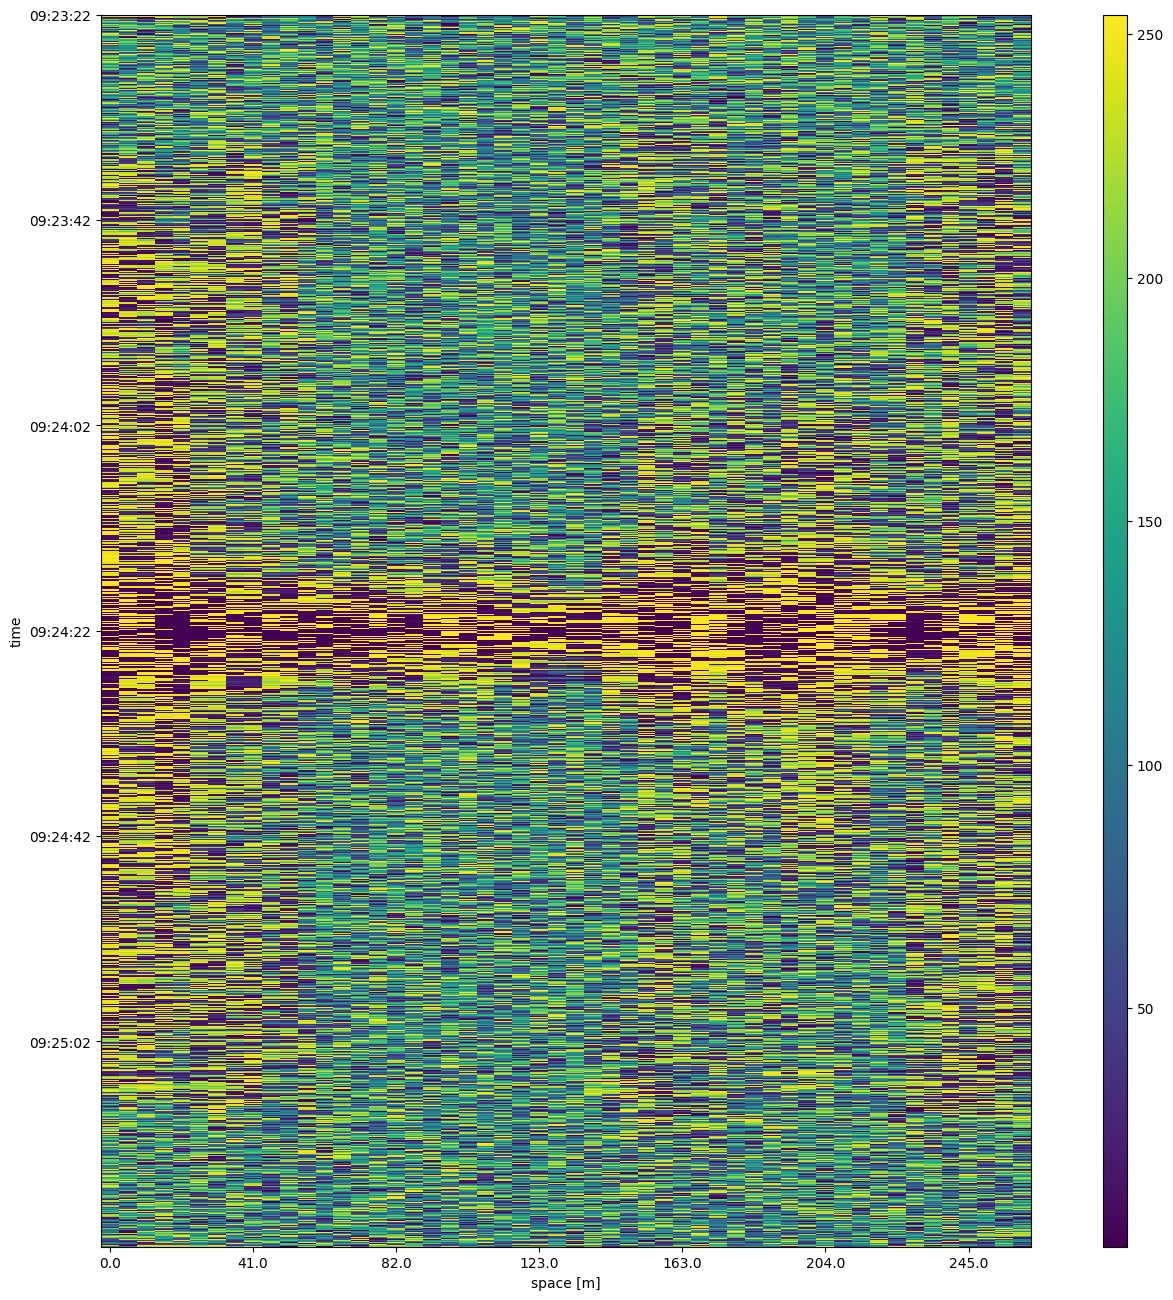

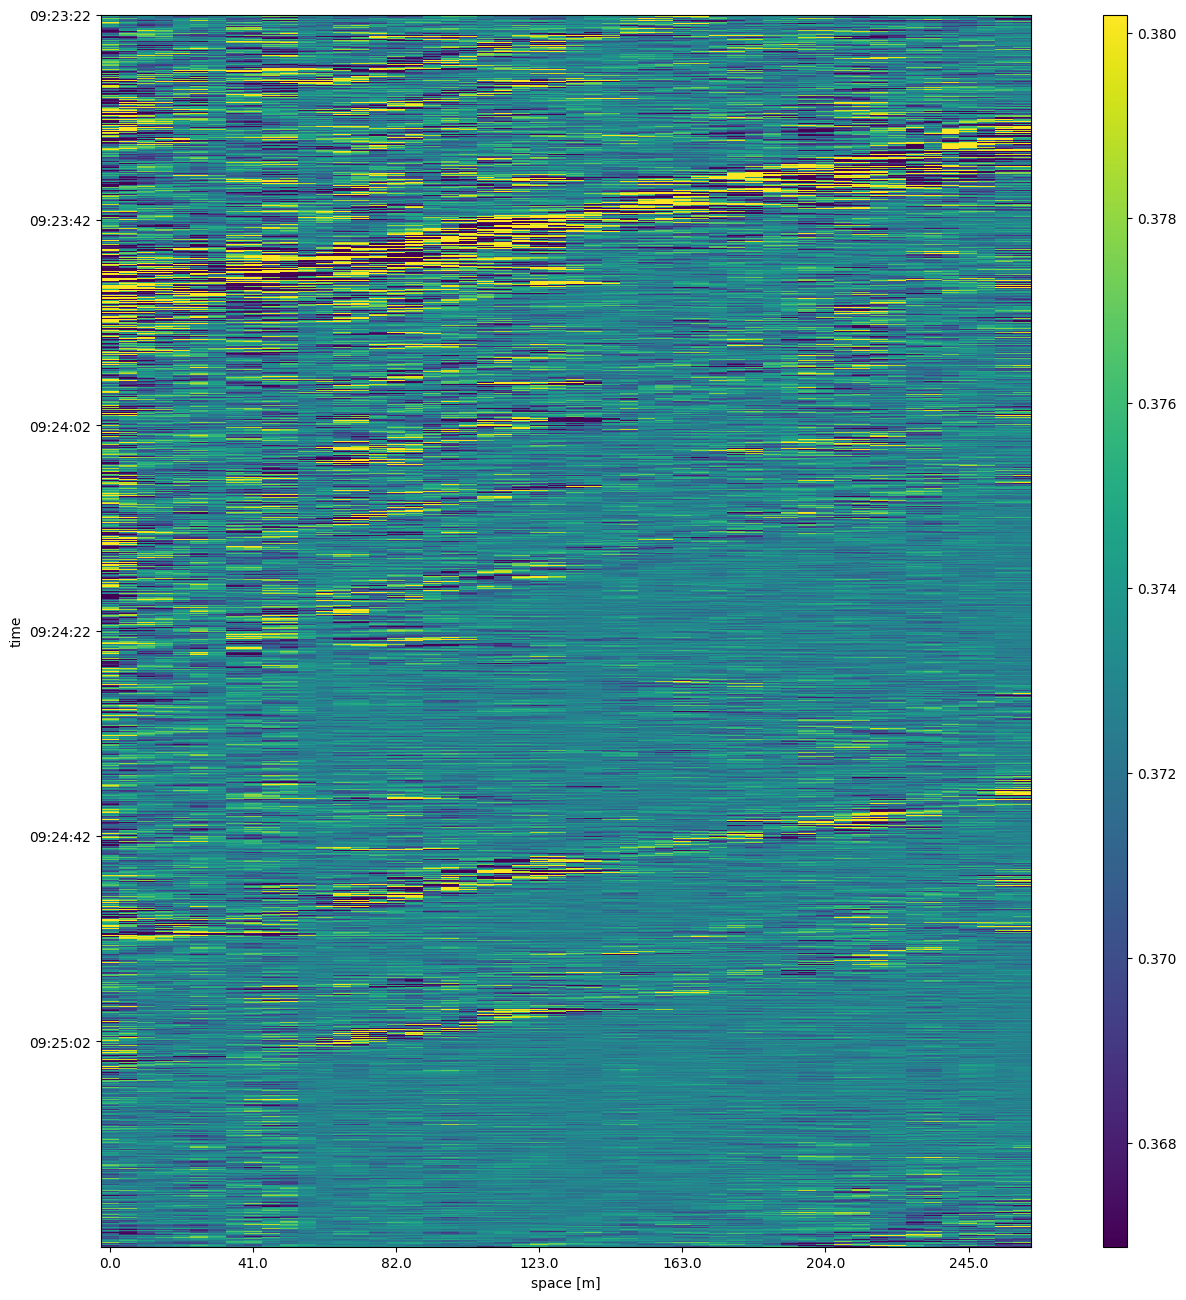

In [334]:
import cv2
# img = np.array(df.values.reshape((2600,1500)))
print(data.shape)
i = np.fft.fft(data, axis = 0)
show_image(np.abs(i))
img = ((i) * 255).astype(np.uint8)
show_image(img)
# i[np.abs(i) < 2] = 0
i_i = np.fft.ifft(i, axis = 0)
show_image(i_i.real)

Below I implemented the data filtering method using fftfreq found **here: https://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html**. My expectations were low, since I couldn't come up with the best way to calculate the frequencies, but the result wasn'tr satisfying at all, the lines were somehow less visible than before. I suspect that the problem lies in my implementation of the high frequency filter.

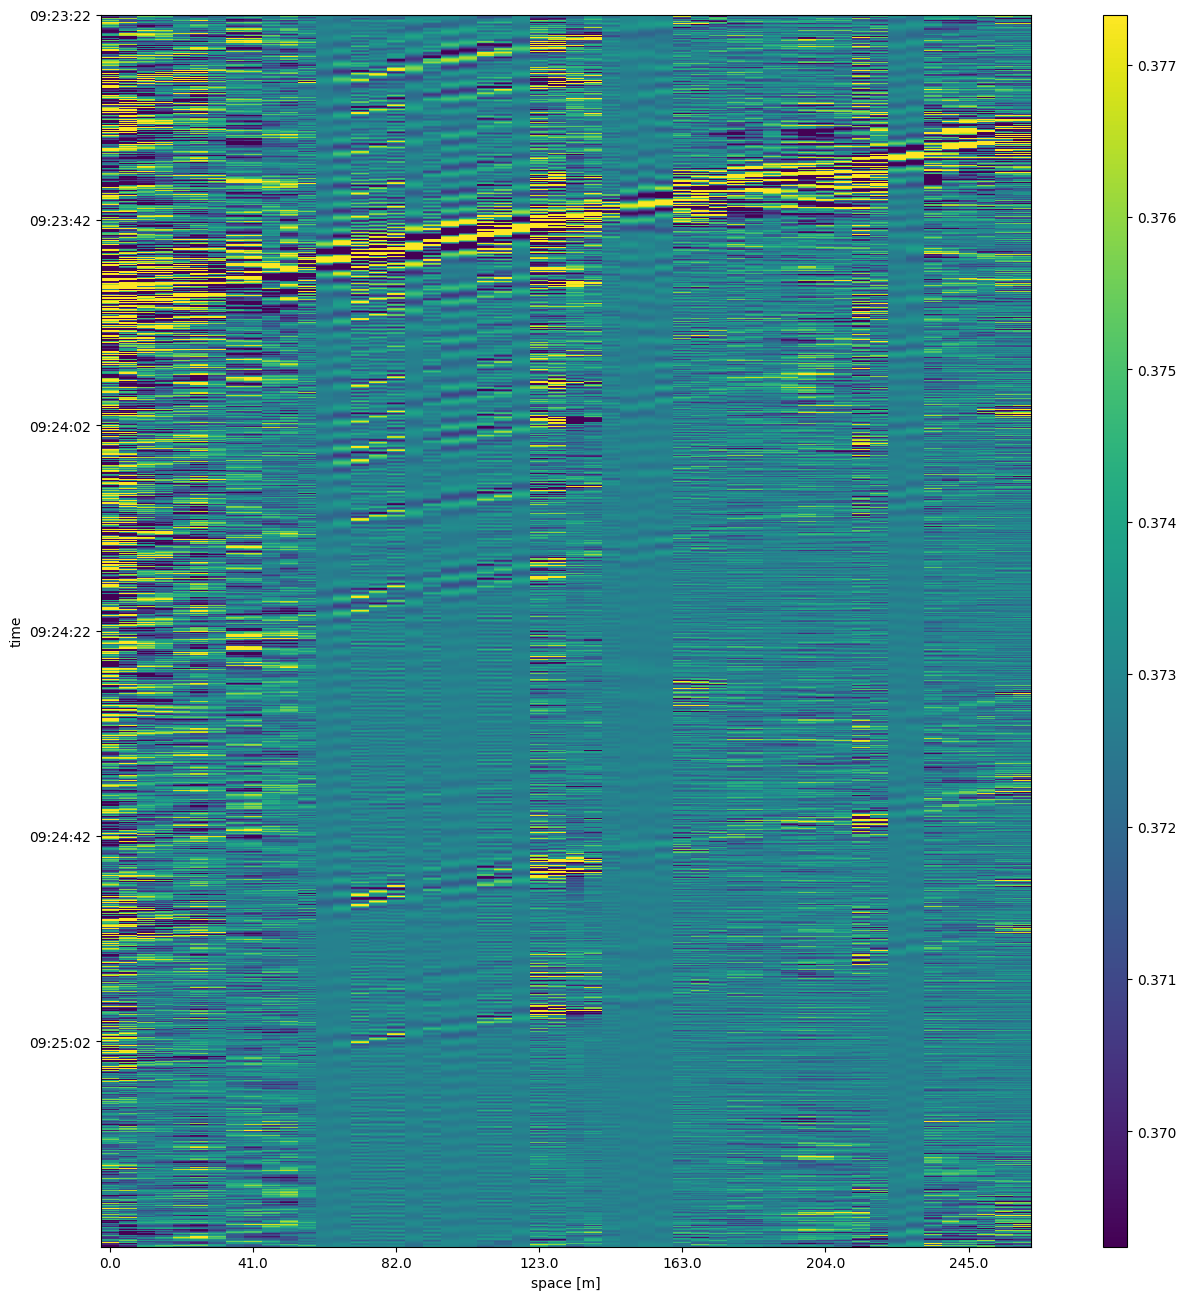

In [335]:
# And the power (sig_fft is of complex dtype)
i = np.fft.fft(data, axis = 0)
power = np.abs(i)**2

time_step = 0.1
# The corresponding frequencies
# Updated to calculate sample_freq based on data shape along axis 0
sample_freq = np.fft.fftfreq(data.shape[0], d=time_step)

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
# Use argmax along axis 0 to find peak frequency for each column
peak_freq_indices = power[pos_mask].argmax(axis = 0)
peak_freqs = freqs[peak_freq_indices]  # Get corresponding frequencies

# Iterate through each column and apply the high-frequency filter
high_freq_fft = i.copy()
for col_idx, peak_freq in enumerate(peak_freqs):
    high_freq_fft[np.abs(sample_freq) > peak_freq, col_idx] = 0


i_i = np.fft.ifft(high_freq_fft, axis=0)
show_image(i_i.real)


I casted the results to the grayscale so that I can use them easier in the next part of the project, however I never used them.

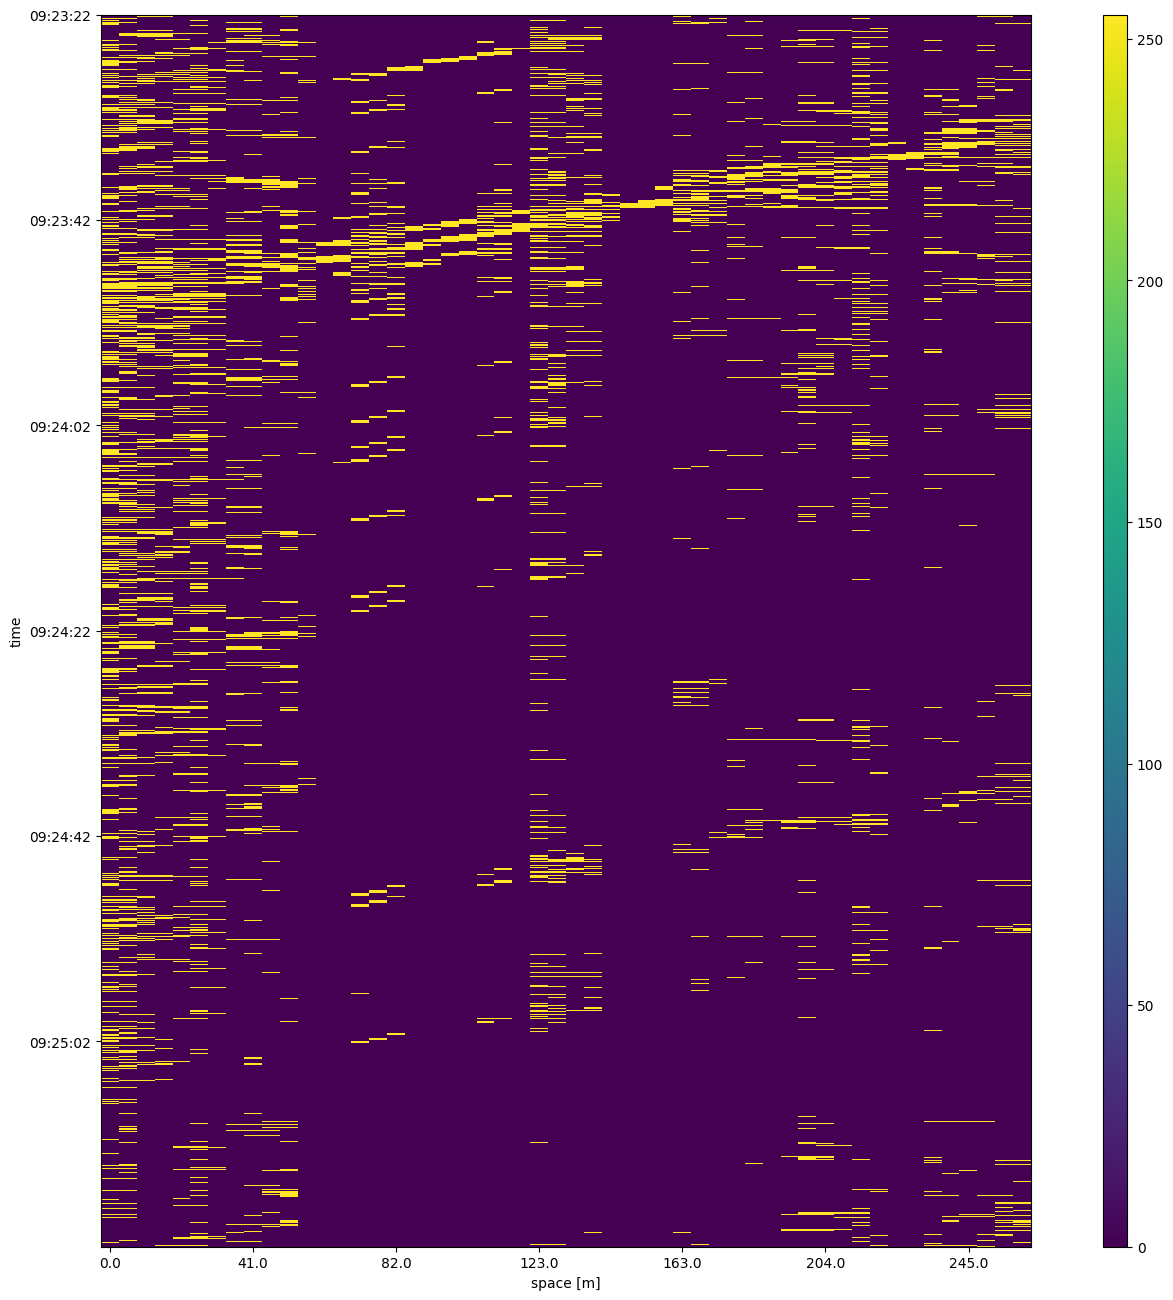

In [336]:
img_space = (i_i>0.375).astype(np.uint8) * 255
show_image(img_space)

I also tried to manipulate the data without the filters introduced in the labs, however I gave up on this idea since I was afraid that a good result from this method might be me 'overfitting' a method for this specific dataset rather than coming up with a good filtering method.

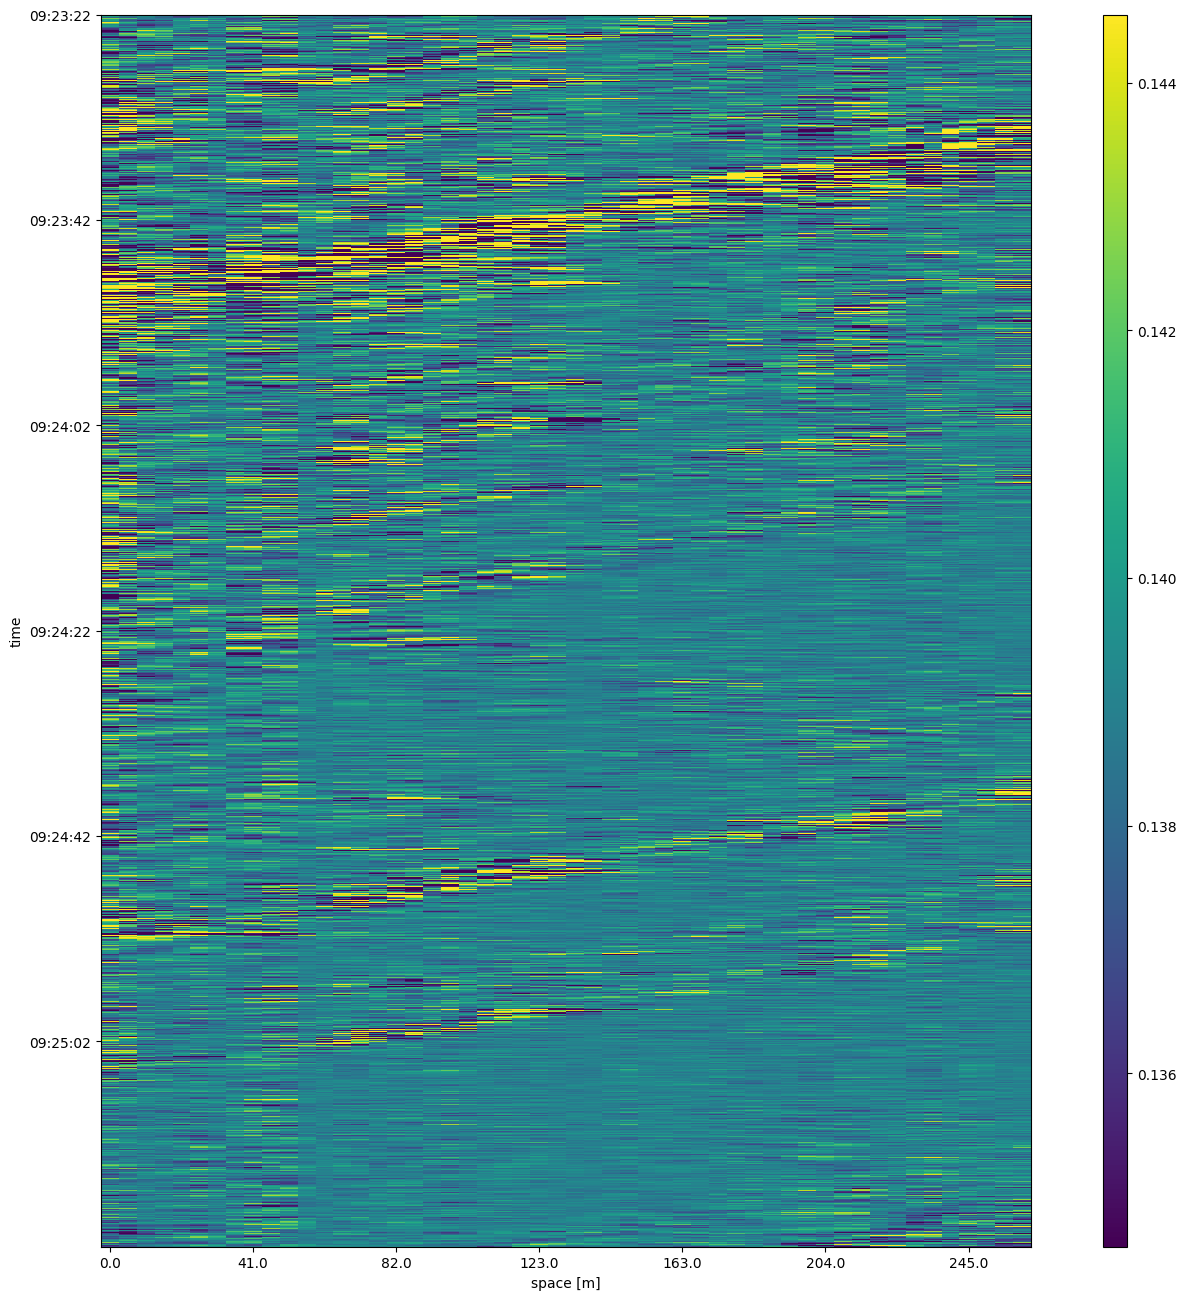

In [337]:
other_filter = data * data

show_image(other_filter)

# AutomedianCV


This method is based on lab 4. I tried to
ProperOpenCV performs a sequence of closing and opening operations to remove small features. ProperCloseCV focuses on preserving larger features while reducing small noise. AutomedianCV combines both opening and closing operations with properOpenCV to perform a median-like filter for noise reduction and feature preservation. I suppose that this image could be used for further processing.

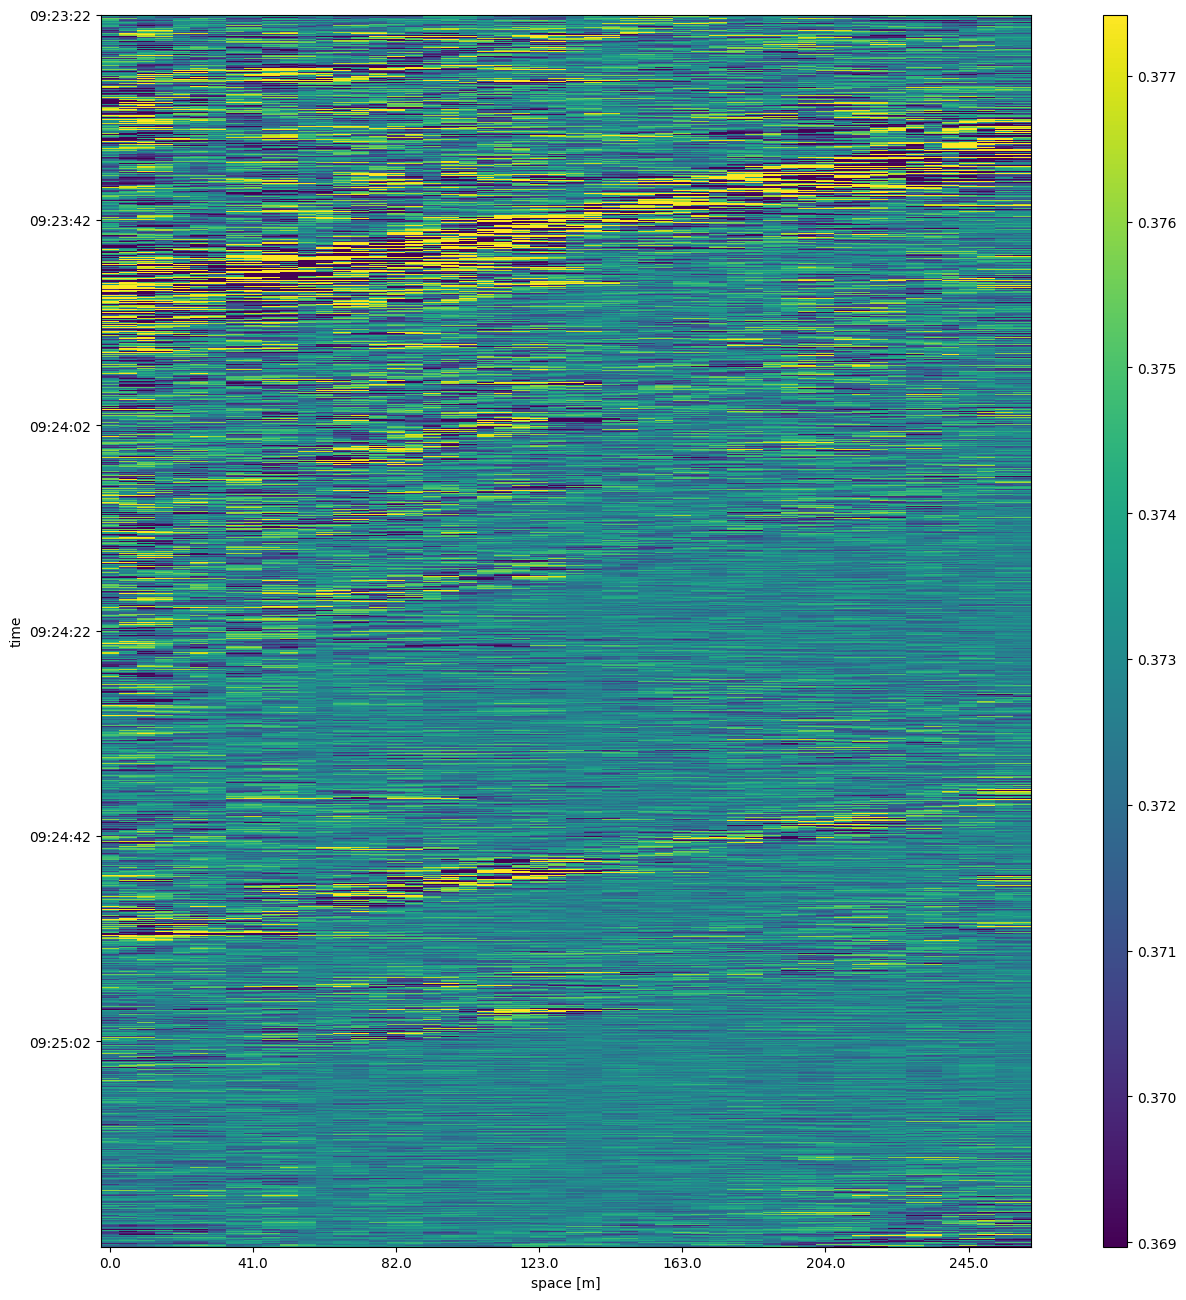

In [338]:
struct = np.ones([5, 5], np.uint8)
def properOpenCV(img,struct):
  result = np.minimum(img,cv2.morphologyEx(cv2.morphologyEx(cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct), cv2.MORPH_OPEN, struct), cv2.MORPH_CLOSE, struct))
  return result
def properCloseCV(img,struct):
  result = np.maximum(img,cv2.morphologyEx(cv2.morphologyEx(cv2.morphologyEx(img, cv2.MORPH_OPEN, struct), cv2.MORPH_CLOSE, struct), cv2.MORPH_OPEN, struct))
  return result
def AutomedianCV(img,struct):
  result =np.maximum(cv2.morphologyEx(cv2.morphologyEx(cv2.morphologyEx(img, cv2.MORPH_OPEN, struct), cv2.MORPH_CLOSE, struct), cv2.MORPH_OPEN, struct),properOpenCV(img,struct))
  return result

img_space_automedianCV = AutomedianCV(data, struct)
show_image(img_space_automedianCV)

[[35 34 34 ... 35 34 34]
 [35 35 34 ... 35 34 34]
 [35 35 34 ... 35 34 34]
 ...
 [35 35 35 ... 34 37 37]
 [35 36 35 ... 36 37 37]
 [35 36 35 ... 36 36 36]]


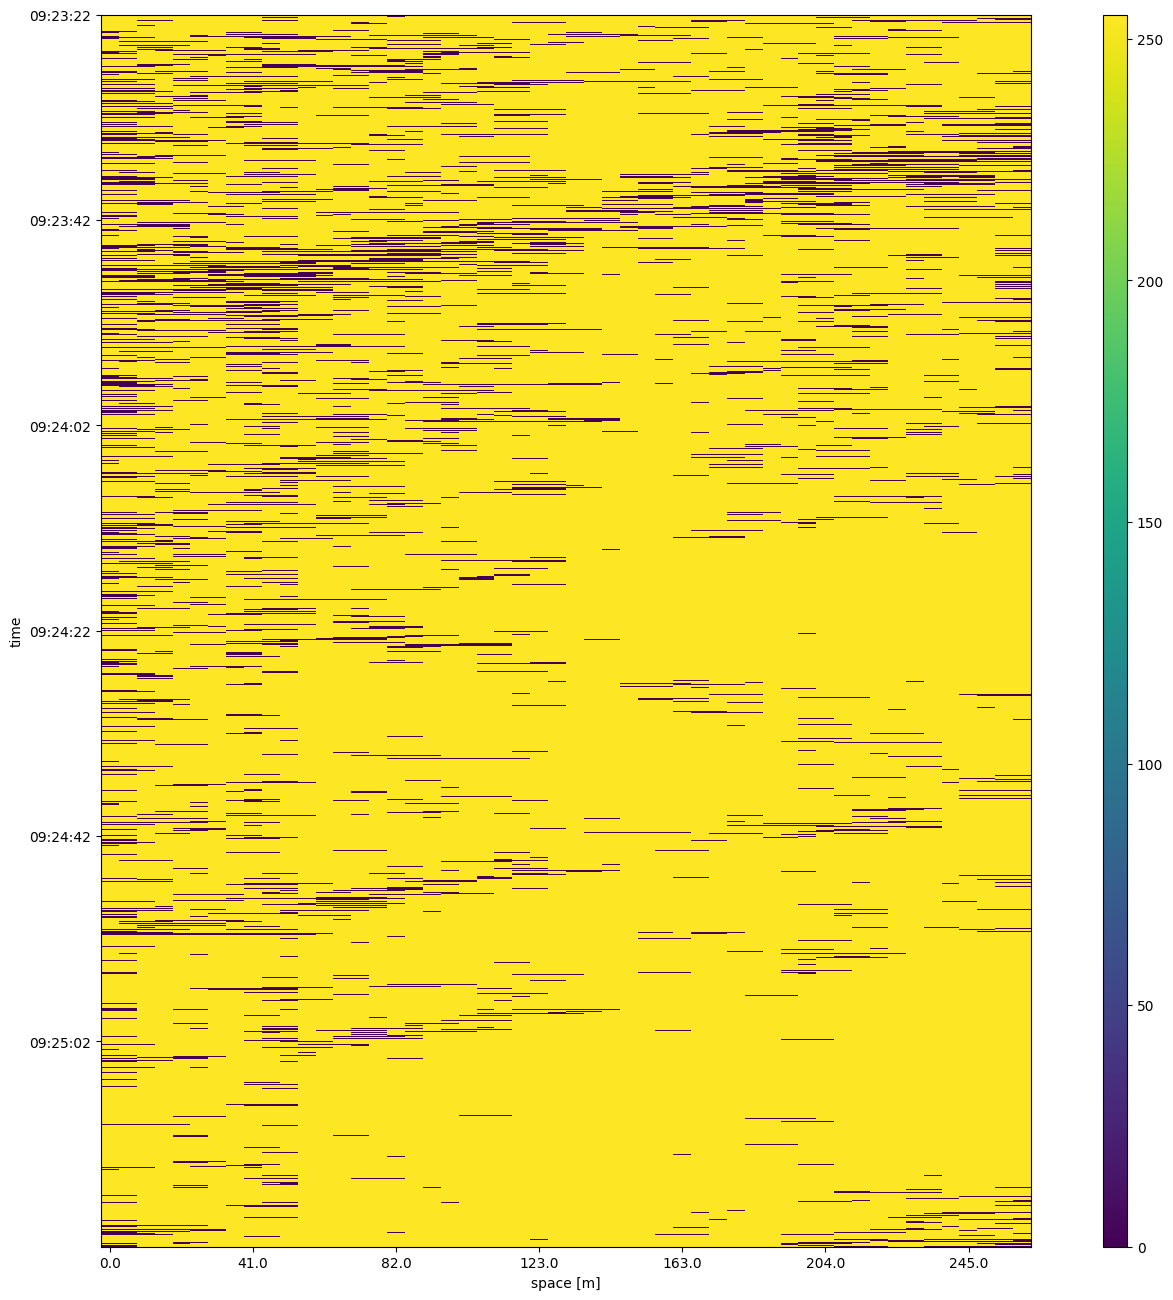

In [339]:
# Otsu's thresholding after Gaussian filtering
img_other = other_filter*255
img_other = img_other.astype(np.uint8)
print(img_other)
blur = cv2.GaussianBlur(img_other,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
show_image(th3)

# Line detection

After filtering I decided to use the approach presented in this post
https://stackoverflow.com/questions/16665742/a-good-approach-for-detecting-lines-in-an-image. The noise filtering is ddne through gaussian smoothing, erosion to reduce the "white" places in the image, intensity to make the features stand out more and the thinning of the image to reduce it to its skeleton. SInce the thinning function didn't work as expected. Alone it didn't producve any visible lines so I had to use probabilistic hough transform to try and extract lines from the image. It didn't work as expected, I suppose it's because of a combination of a wrong order of operations or the hough lines detecting straight lines with a 90 degrees angle.


Since the detected lines seemed promising, I changed my approach a bit and after detecting lines for the first time I dilated them, then used the skeletonization and hough transform and it gave satisfying results. However my implementation proved to be a bit unstable and the results detected by image skeletonization change with each run. I included the images from my best run, since the later ones proved to be less efficient.


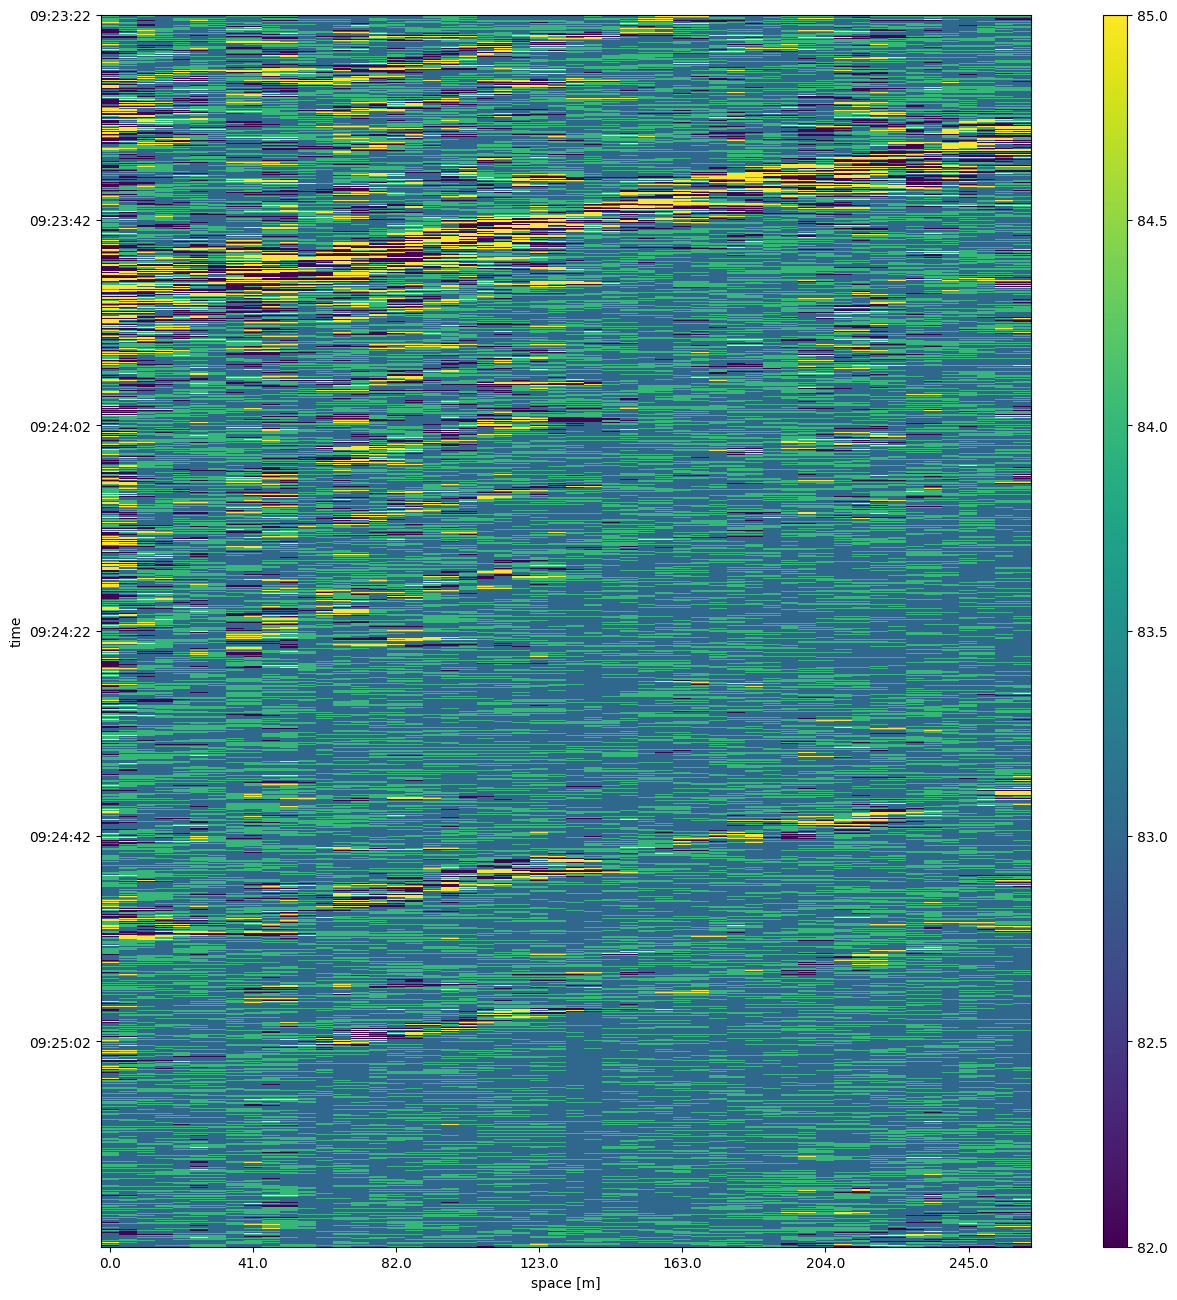

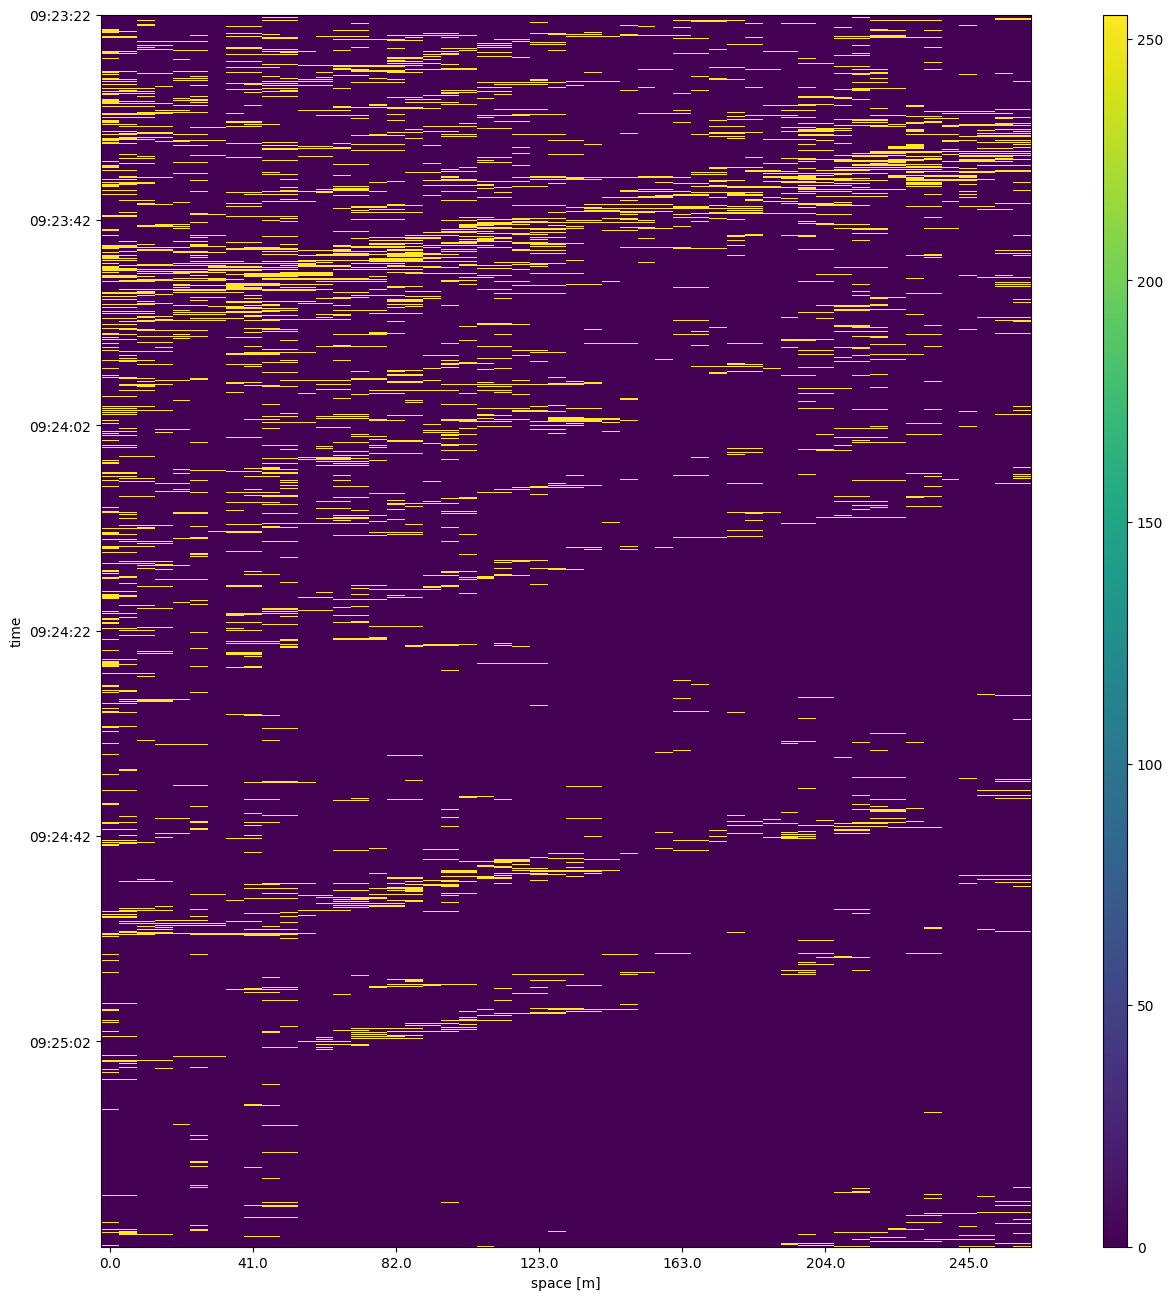

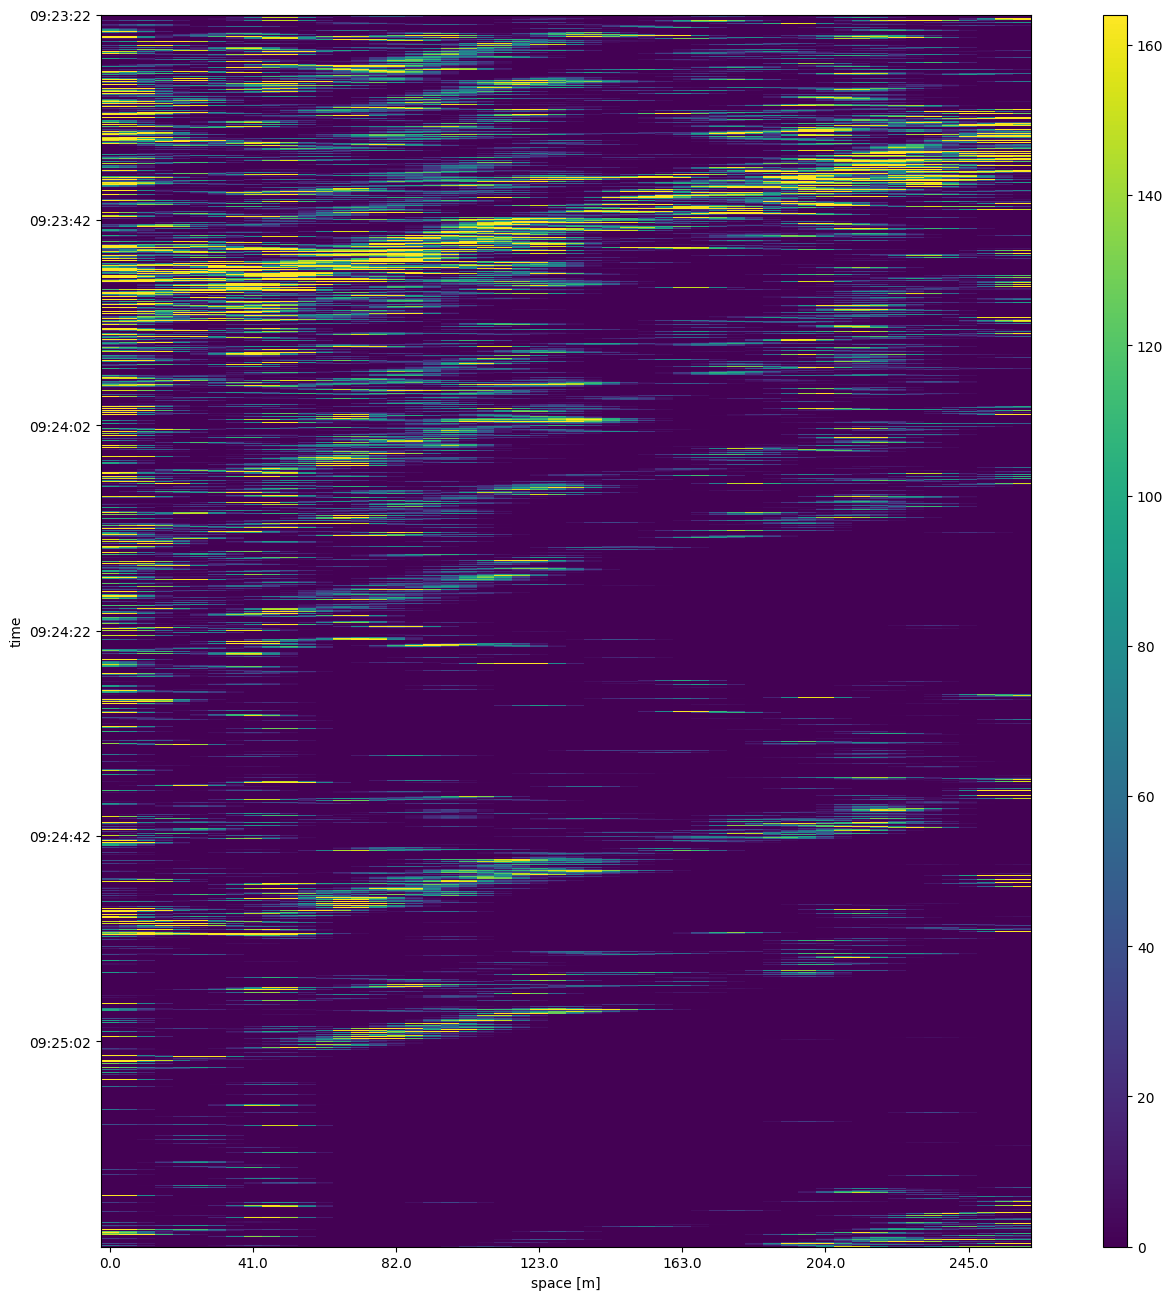

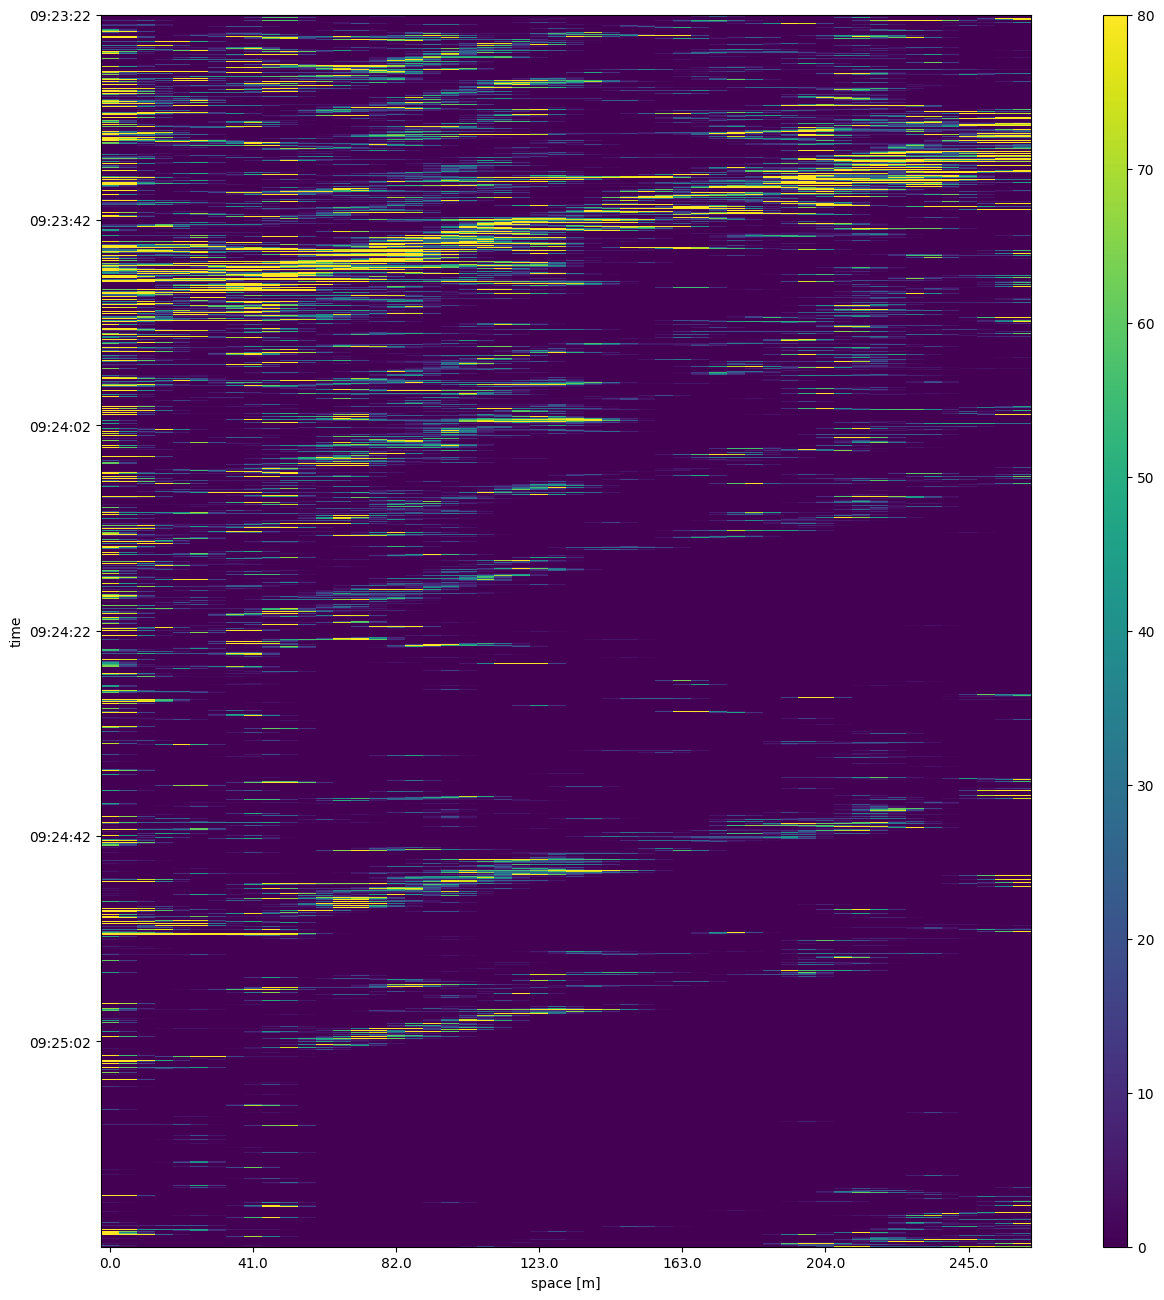

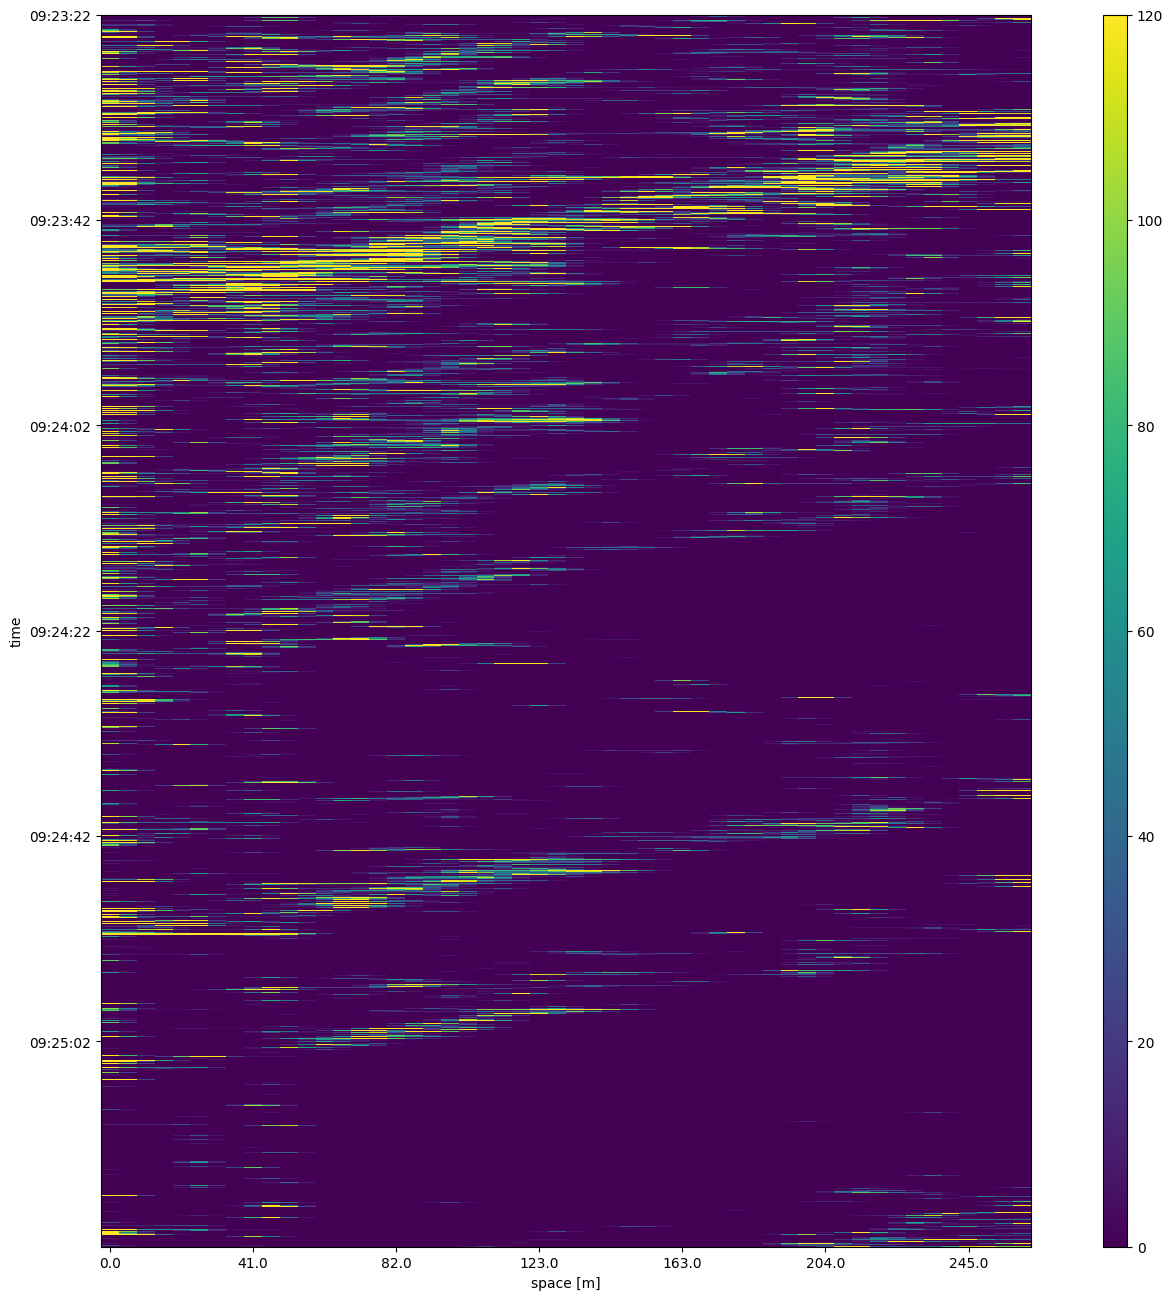

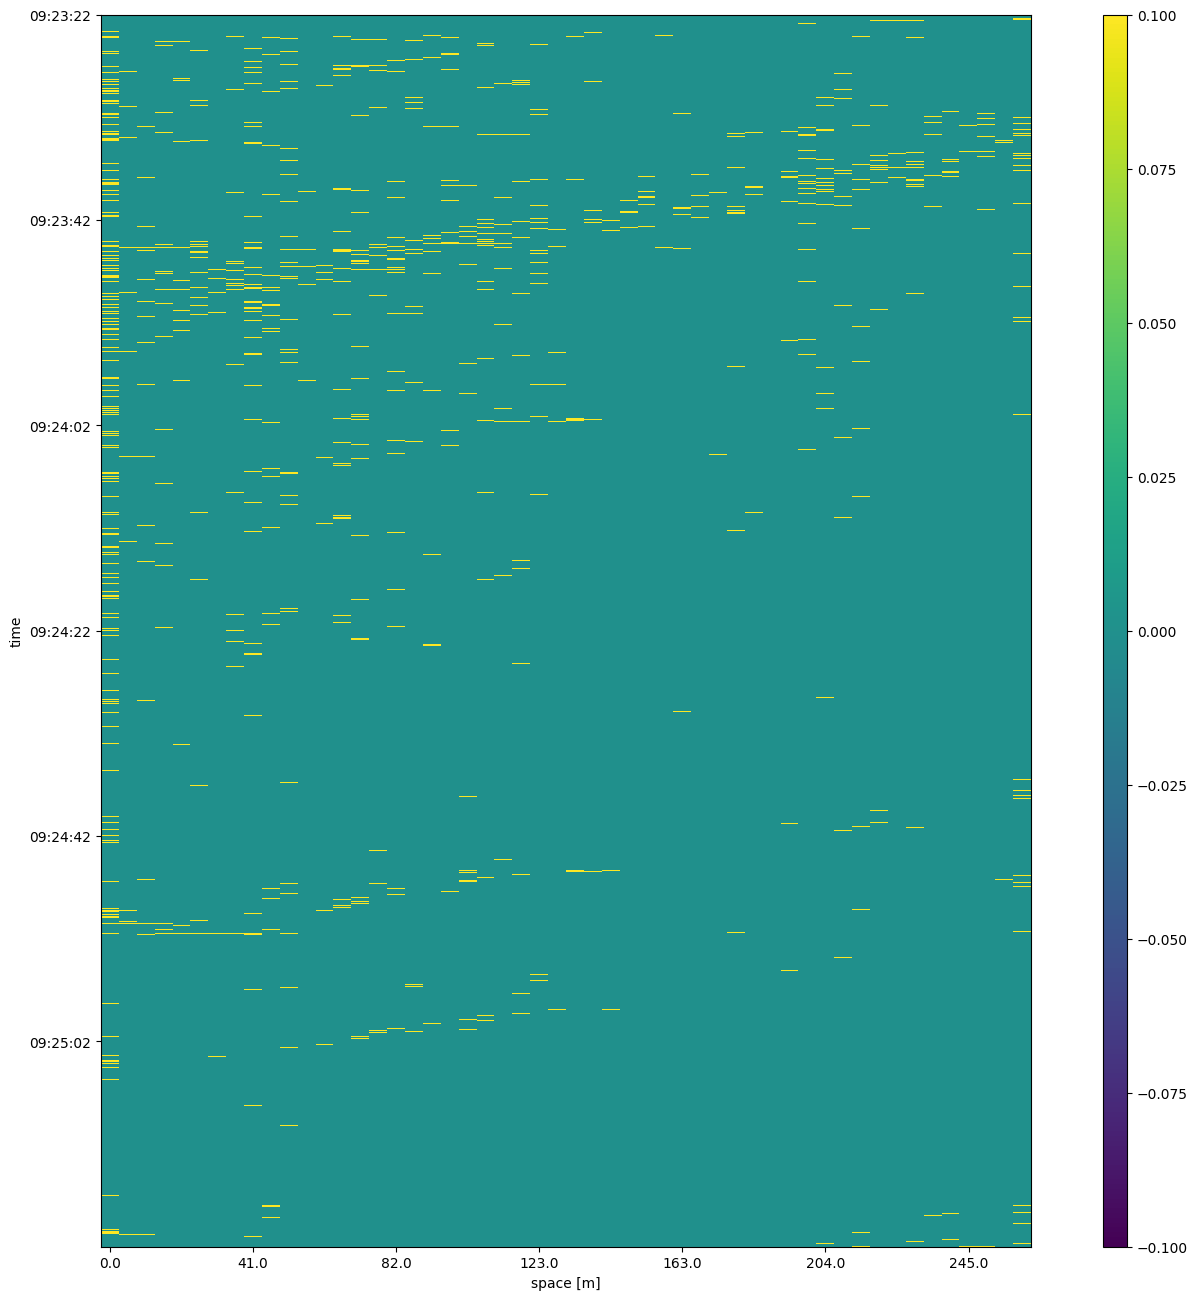

In [353]:
from PIL import Image
import skimage
img_gray = data * 225
img_gray = img_gray.astype(np.uint8)
show_image(img_gray)
_, binary_image = cv2.threshold(img_gray, 82, 255, cv2.THRESH_BINARY)
binary_image = ~binary_image
show_image(binary_image)
# kernel = np.ones((5, 5), np.uint8)
# img_dilation = cv2.dilate(binary_image, kernel, iterations=1)
# img_dilation
blur = cv2.GaussianBlur(binary_image,(5,5),0)
show_image(blur)
erode = cv2.erode(blur ,np.ones((3,3)),iterations = 1)
show_image(erode)

intensity_factor = 1.5
intensified_image = np.clip(erode * intensity_factor, 0, 255).astype(np.uint8)
show_image(intensified_image)
thinned_image = skimage.morphology.medial_axis(intensified_image > 100)
thinned_image = thinned_image.astype(np.uint8) * 255
show_image(thinned_image)

array([[15, 15, 15, ..., 36, 36, 36],
       [30, 30, 30, ..., 44, 44, 44],
       [ 1,  1,  1, ..., 34, 34, 34],
       ...,
       [12, 12, 12, ..., 10, 10, 10],
       [16, 16, 16, ...,  8,  8,  8],
       [ 1,  1,  1, ...,  6,  6,  6]], dtype=uint8)
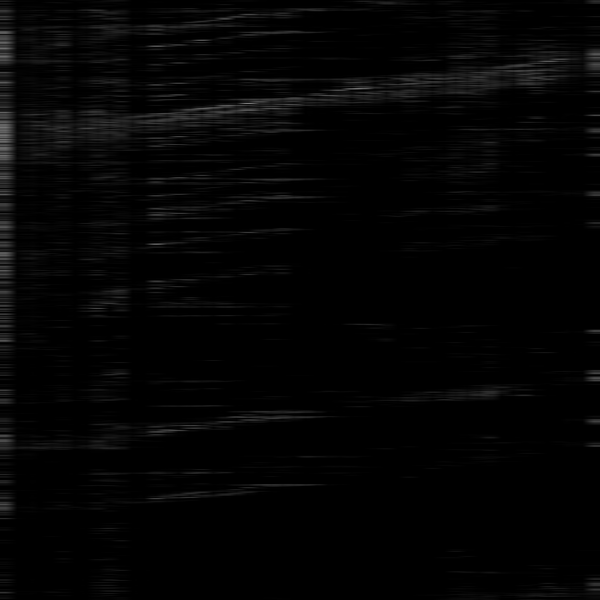

In [354]:
from PIL import Image
import skimage

# ... your existing code ...

# Resize the image using Image.Resampling.LANCZOS
thinned_image_pil = Image.fromarray(thinned_image)  # Convert to PIL Image
thinned_image_pil = thinned_image_pil.resize((600, 600), Image.Resampling.LANCZOS)  # Resize
thinned_image = np.array(thinned_image_pil)  # Convert back to NumPy array

thinned_image

In [355]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 400  # minimum number of pixels making up a line
max_line_gap = 2  # maximum gap in pixels between connectable line segments
line_image = np.copy(thinned_image) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(thinned_image, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

array([[12, 12, 12, ..., 29, 29, 29],
       [24, 24, 24, ..., 35, 35, 35],
       [ 1,  1,  1, ..., 27, 27, 27],
       ...,
       [10, 10, 10, ...,  8,  8,  8],
       [13, 13, 13, ...,  6,  6,  6],
       [ 1,  1,  1, ...,  5,  5,  5]], dtype=uint8)
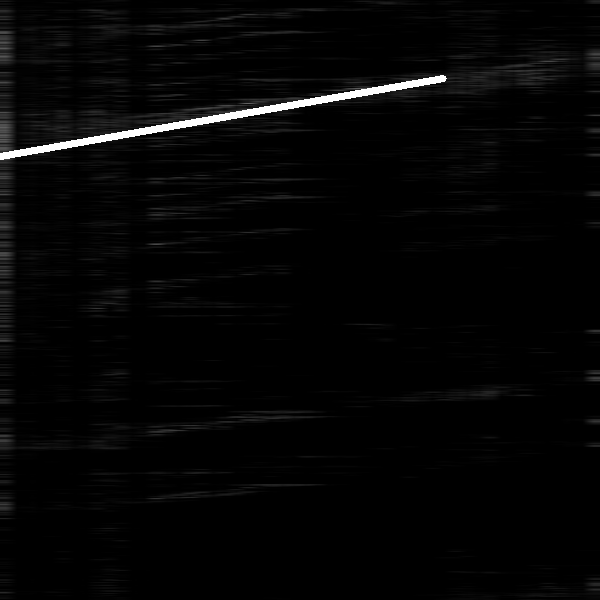

In [356]:
# Draw the lines on the  image
lines_edges = cv2.addWeighted(thinned_image, 0.8, line_image, 1, 0)
lines_edges

array([[24, 24, 24, ..., 35, 35, 35],
       [24, 24, 24, ..., 35, 35, 35],
       [24, 24, 24, ..., 35, 35, 35],
       ...,
       [13, 13, 13, ...,  8,  8,  8],
       [13, 13, 13, ...,  8,  8,  8],
       [13, 13, 13, ...,  8,  8,  8]], dtype=uint8)
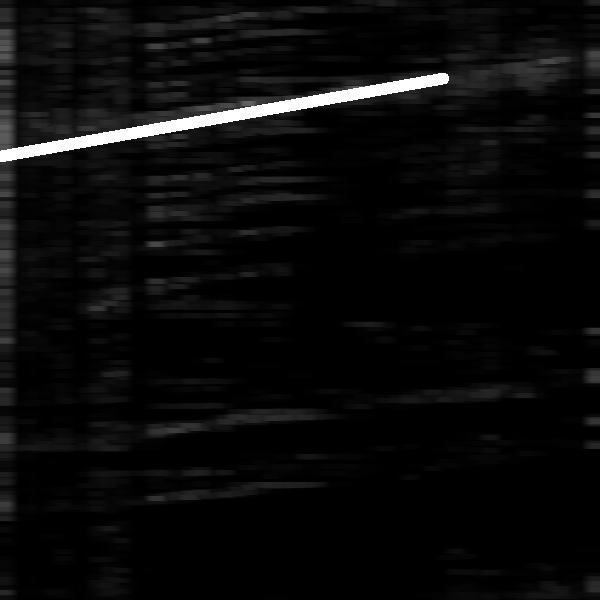

In [357]:
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(lines_edges, kernel, iterations=1)
img_dilation

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
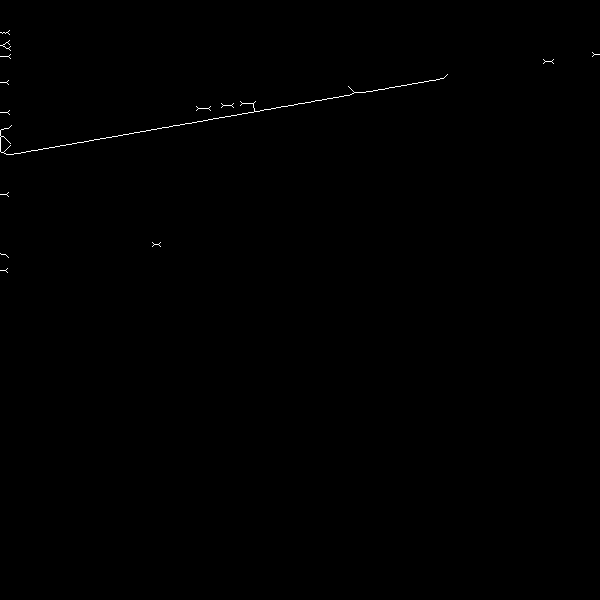

In [358]:
intensity_factor = 1.5
intensified_image_2 = np.clip(img_dilation * intensity_factor, 0, 255).astype(np.uint8)
thinned_image_2 = skimage.morphology.medial_axis(intensified_image_2 > 100)
thinned_image_2 = thinned_image_2.astype(np.uint8) * 255
thinned_image_2

In [359]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 40  # maximum gap in pixels between connectable line segments
line_image_2 = np.copy(thinned_image_2) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines_2 = cv2.HoughLinesP(thinned_image_2, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines_2:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_2,(x1,y1),(x2,y2),(255,0,0),5)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
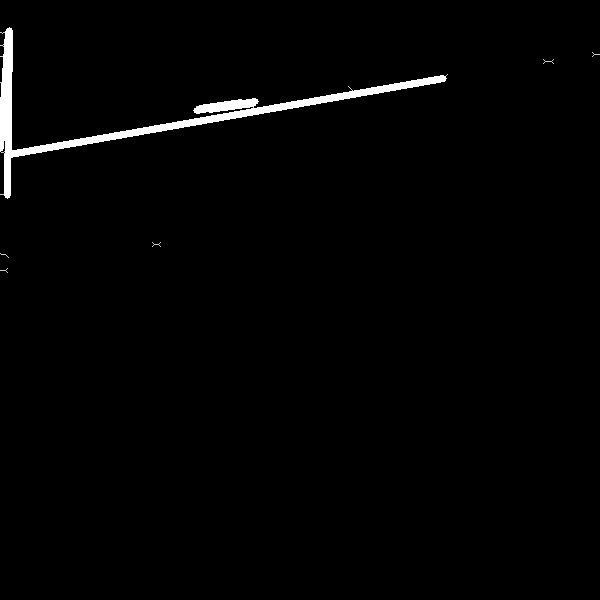

In [360]:
lines_edges_2 = cv2.addWeighted(thinned_image_2, 0.8, line_image_2, 1, 0)
lines_edges_2


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
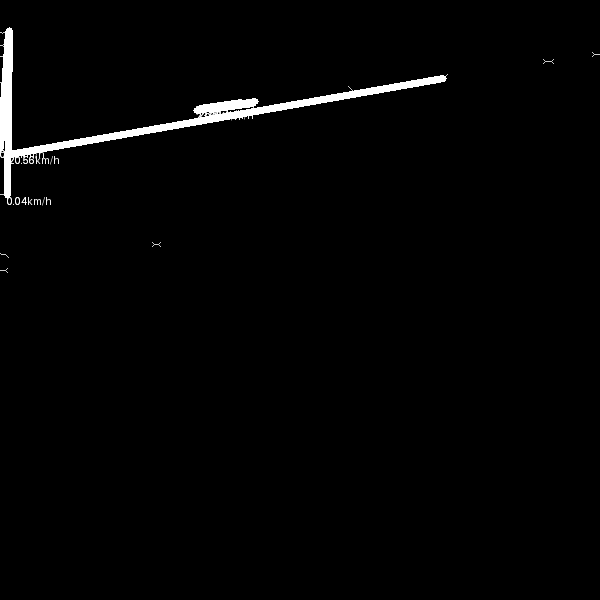

In [362]:
from PIL import ImageDraw
pil_image = Image.fromarray(lines_edges_2)
for line in lines_2:
    for x1, y1, x2, y2 in line:
        len_y = np.abs(y2 - y1)
        len_x = np.abs(x2 - x1)
        if len_y == 0:
          continue
        velocity = len_x/len_y * 3.6
        if velocity > 100:
          continue

        I1 = ImageDraw.Draw(pil_image)
        I1.text((x1, y1), str(round(velocity,2)) + 'km/h' , fill=255)
lines_edges_2 = np.array(pil_image)
lines_edges_2

# Best run

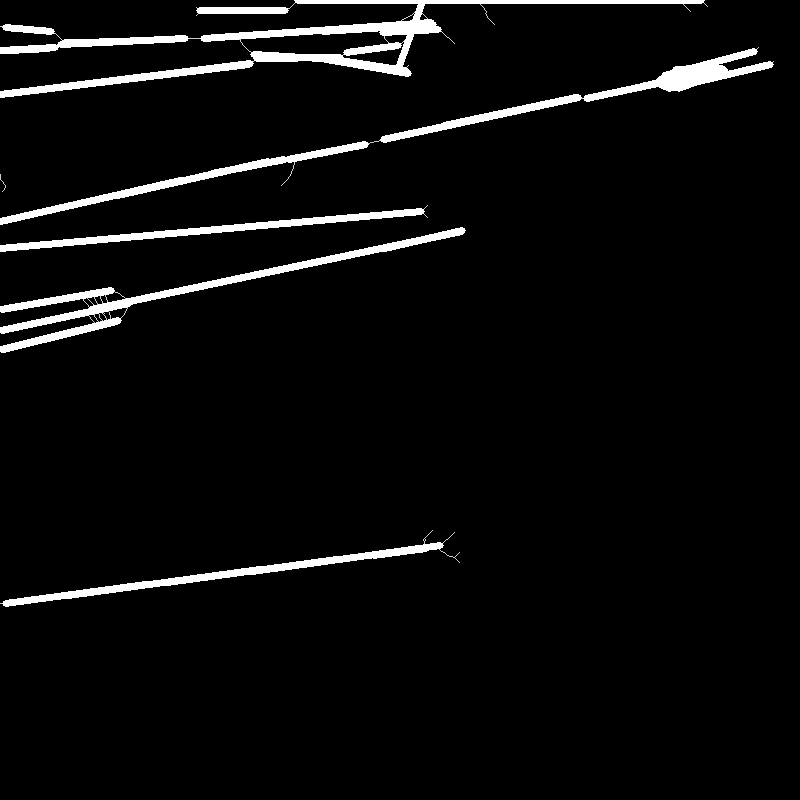